# 构建自己的网络

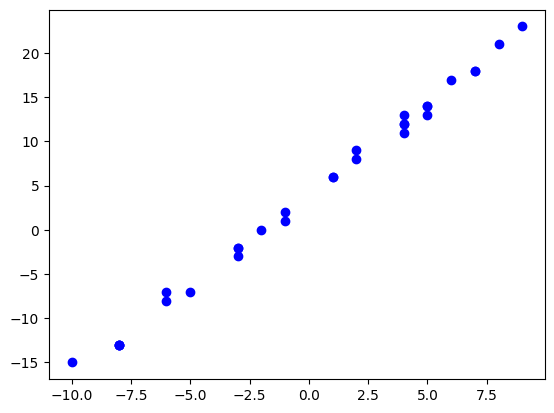

In [3]:
import numpy as np
import random 
from matplotlib import pyplot as plt

w = 2 
b = 3 
xlim = [-10, 10]
x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)

y_train = [w*x + b + random.randint(0,2) for x in x_train]
plt.plot(x_train, y_train, 'bo')


In [7]:
import torch
from torch import nn
class LinearModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1))
    def forward(self, input):
        return (input* self.weight)+self.bias

model = LinearModel()
x = torch.tensor(3)
y = model(x)
print(y)

tensor([3.2405], grad_fn=<AddBackward0>)


In [8]:
from doctest import OutputChecker


model = LinearModel()
optimizer = torch.optim.SGD(model.parameters(), 
lr=1e-4,
weight_decay=1e-2,
momentum=0.9
)
y_train = torch.tensor(y_train, dtype=torch.float32)

for _ in range(1000):
    input = torch.from_numpy(x_train)
    output = model(input)
    loss = nn.MSELoss()(output, y_train)
    model.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
for parameter in model.named_parameters():
    print(parameter)

('weight', Parameter containing:
tensor([2.0503], requires_grad=True))
('bias', Parameter containing:
tensor([3.3961], requires_grad=True))


## 模型的保存与加载
### 仅保存参数
### 保存模型+参数

In [11]:
# 保存参数
torch.save(model.state_dict(), './linear_model.pth')

#加载时,需要提前构建网络
linear_model = LinearModel()
linear_model.load_state_dict(torch.load('./linear_model.pth'))
## Sets the module in evaluation mode.  This is equivalent with self.train(False)
linear_model.eval()

for parameter in linear_model.named_parameters():
    print(parameter)

('weight', Parameter containing:
tensor([2.0503], requires_grad=True))
('bias', Parameter containing:
tensor([3.3961], requires_grad=True))


In [12]:
## 保存模型与参数
torch.save(model, './linear_model_with_arc.pth')

## 加载模型与参数
linear_model_2 = torch.load('./linear_model_with_arc.pth')
## Sets the module in evaluation mode.
linear_model_2.eval()

for parameter in linear_model_2.named_parameters():
    print(parameter)


('weight', Parameter containing:
tensor([2.0503], requires_grad=True))
('bias', Parameter containing:
tensor([3.3961], requires_grad=True))


# 使用torchvision中的模型进行训练
* 微调关键在于调整最后全连接层的输出的数目

In [23]:
import torchvision.models as models
alexnet = models.alexnet(pretrained = True)
# 直接打印就可以看到网络结构
print(alexnet)

/home/bliss/.conda/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/bliss/.conda/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
from PIL import Image 
import torchvision
import torchvision.transforms as transforms

im = Image.open('images/construct-network-2022-09-30-11-08-07.png')

transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

input_tensor = transform(im).unsqueeze(0)
alexnet(input_tensor).argmax()

tensor(264)

## cifar10 数据集为例微调所有参数

Files already downloaded and verified
torch.Size([32, 3, 32, 32])


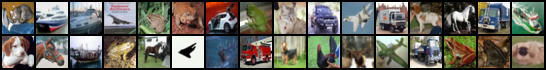

In [32]:
#CIFAR10 数据查看
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

cifar10_dataset = torchvision.datasets.CIFAR10(
    root="~/project/datasets",
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

tensor_dataloader = DataLoader(dataset=cifar10_dataset,
batch_size=32)

data_iter = iter(tensor_dataloader)
img_tensor, label_tensor = data_iter.next()
print(img_tensor.shape)

grid_tensor = torchvision.utils.make_grid(img_tensor, nrow=16, padding=2)
grid_img = transforms.ToPILImage()(grid_tensor)

display(grid_img)

In [33]:
# 修改网络 全连接层参数
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import torchvision.models as models
alexnet = models.alexnet(pretrained = True)

print(alexnet)
#alextnet 分类层的输入参数
fc_in_features = alexnet.classifier[6].in_features
#Applies a linear transformation to the incoming data:
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10)

print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
#prepare network construct
alexnet = models.alexnet(pretrained = True)

print(alexnet)
#alextnet 分类层的输入参数
fc_in_features = alexnet.classifier[6].in_features
#Applies a linear transformation to the incoming data:
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10)

print(alexnet)

#prepare dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

cifar10_dataset = torchvision.datasets.CIFAR10(
    root="~/project/datasets",
    train=False,
    transform=transform,
    target_transform=None,
    download=True
)

tensor_dataloader = DataLoader(dataset=cifar10_dataset,
batch_size=32,
shuffle=True,
num_workers=2)


optimizer = torch.optim.SGD(alexnet.parameters(),
lr=1e-4,
weight_decay=1e-2,
momentum=0.9)

for epoch in range(3):
    for item in tensor_dataloader:
        output = alexnet(item[0])
        target = item[1]

        loss = nn.CrossEntropyLoss()(output, target)
        print('Epoch {},  Loss{}'.format(epoch+1,loss))

        alexnet.zero_grad()
        loss.backward()
        optimizer.step()

Files already downloaded and verified
Epoch 1,Loss2.531787872314453
Epoch 1,Loss2.422750234603882
Epoch 1,Loss2.3191654682159424
Epoch 1,Loss2.4886553287506104
Epoch 1,Loss2.3533291816711426
Epoch 1,Loss2.3713178634643555
Epoch 1,Loss2.276768684387207
Epoch 1,Loss2.304677963256836
Epoch 1,Loss2.258303642272949
Epoch 1,Loss2.297464370727539
Epoch 1,Loss2.2794392108917236
Epoch 1,Loss2.3593287467956543
Epoch 1,Loss2.3901801109313965
Epoch 1,Loss2.301971673965454
Epoch 1,Loss2.3592922687530518
Epoch 1,Loss2.1655211448669434
Epoch 1,Loss2.3372578620910645
Epoch 1,Loss2.2819862365722656
Epoch 1,Loss2.1643645763397217
Epoch 1,Loss2.305263042449951
Epoch 1,Loss2.196976661682129
Epoch 1,Loss2.2381973266601562
Epoch 1,Loss2.1861982345581055
Epoch 1,Loss2.207980155944824
Epoch 1,Loss2.253443956375122
Epoch 1,Loss2.1323416233062744
Epoch 1,Loss2.1195929050445557
Epoch 1,Loss2.14042592048645
Epoch 1,Loss2.116387367248535
Epoch 1,Loss2.225358247756958
Epoch 1,Loss1.9992824792861938
Epoch 1,Loss2.15

## 固定网络参数，只训练全连接层
* 在读取完预训练模型后，将全连接之前的参数全部锁死

In [ ]:
alexnet = models.alexnet()
alexnet.load_state_dict(torch.load('./model/alexnet.pth'))

for param in alexnet.parameters():
    param.requires_grad = False